In [1]:
import math

# Định nghĩa các hằng số
SAMP_FREQ = 4000  # Tần số mẫu, cần được định nghĩa ở đây nếu chưa có
NUM_FRAMES = 30
NUM_MFCC_COEFFS = 10
MFCC_DEC_BITS = 4
FRAME_SHIFT_MS = 100
FRAME_LEN_MS = 100

# Tính toán các giá trị
FRAME_SHIFT = int(SAMP_FREQ * 0.001 * FRAME_SHIFT_MS)
MFCC_BUFFER_SIZE = NUM_FRAMES * NUM_MFCC_COEFFS
FRAME_LEN = int(SAMP_FREQ * 0.001 * FRAME_LEN_MS)

# Khởi tạo các biến
num_frames = NUM_FRAMES
num_mfcc_features = NUM_MFCC_COEFFS
frame_shift = FRAME_SHIFT
recording_win = NUM_FRAMES
frame_len = FRAME_LEN
mfcc_dec_bits = MFCC_DEC_BITS


In [31]:
import numpy as np
from scipy.fftpack import dct
from scipy.fft import rfft, rfftfreq

class MFCC:
    def __init__(self, num_mfcc_features, frame_len, mfcc_dec_bits):
        self.num_mfcc_features = num_mfcc_features
        self.frame_len = frame_len
        self.mfcc_dec_bits = mfcc_dec_bits
        
        # Round-up to nearest power of 2
        self.frame_len_padded = 2 ** int(np.ceil(np.log2(frame_len)))
        
        self.frame = np.zeros(self.frame_len_padded)
        self.buffer = np.zeros(self.frame_len_padded)
        self.mel_energies = np.zeros(10)
        
        # Create window function
        self.window_func = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(self.frame_len) / self.frame_len)
        
        # Create mel filterbank
        self.mel_fbank, self.fbank_filter_first, self.fbank_filter_last = self.create_mel_fbank()
        
        # Create DCT matrix
        self.dct_matrix = self.create_dct_matrix(10, num_mfcc_features)
        
    def mel_scale(self, freq):
        return 1127.0 * np.log1p(freq / 700.0)
    
    def inverse_mel_scale(self, mel_freq):
        return 700.0 * (np.exp(mel_freq / 1127.0) - 1.0)
    
    def create_dct_matrix(self, input_length, coefficient_count):
        M = np.zeros((coefficient_count, input_length))
        normalizer = np.sqrt(2.0 / input_length)
        for k in range(coefficient_count):
            for n in range(input_length):
                M[k, n] = normalizer * np.cos(np.pi / input_length * (n + 0.5) * k)
        return M
    
    def create_mel_fbank(self):
        num_fbanks = 10
        num_fft_bins = self.frame_len_padded // 2
        fft_bin_width = 4000.0 / self.frame_len_padded
        mel_low_freq = self.mel_scale(80)
        mel_high_freq = self.mel_scale(2000)
        mel_freq_delta = (mel_high_freq - mel_low_freq) / (num_fbanks + 1)
        
        mel_fbank = []
        fbank_filter_first = np.zeros(num_fbanks, dtype=int)
        fbank_filter_last = np.zeros(num_fbanks, dtype=int)
        
        for bin in range(num_fbanks):
            left_mel = mel_low_freq + bin * mel_freq_delta
            center_mel = mel_low_freq + (bin + 1) * mel_freq_delta
            right_mel = mel_low_freq + (bin + 2) * mel_freq_delta
            
            first_index, last_index = -1, -1
            this_bin = np.zeros(num_fft_bins)
            
            for i in range(num_fft_bins):
                freq = fft_bin_width * i
                mel = self.mel_scale(freq)
                if left_mel < mel < right_mel:
                    weight = (mel - left_mel) / (center_mel - left_mel) if mel <= center_mel else (right_mel - mel) / (right_mel - center_mel)
                    this_bin[i] = weight
                    if first_index == -1:
                        first_index = i
                    last_index = i
            
            fbank_filter_first[bin] = first_index
            fbank_filter_last[bin] = last_index
            mel_fbank.append(this_bin[first_index:last_index + 1])
        
        return mel_fbank, fbank_filter_first, fbank_filter_last
    
    def mfcc_compute(self, audio_data):
        # Normalize and apply window function
        self.frame[:self.frame_len] = audio_data / (1 << 15)
        self.frame[:self.frame_len] *= self.window_func
        
        # Compute FFT
        fft_result = rfft(self.frame)
        power_spectrum = np.abs(fft_result) ** 2
        power_spectrum[0] = power_spectrum[1] = np.mean(power_spectrum[1:3])  # Handle DC and Nyquist
        
        # Apply Mel filterbanks
        for bin in range(10):
            first_index = self.fbank_filter_first[bin]
            last_index = self.fbank_filter_last[bin]
            mel_energy = np.sum(np.sqrt(power_spectrum[first_index:last_index + 1]) * self.mel_fbank[bin])
            self.mel_energies[bin] = mel_energy if mel_energy > 0 else np.finfo(float).tiny
        
        # Take log
        self.mel_energies = np.log(self.mel_energies)
        
        # Take DCT
        mfcc_out = self.mel_energies
        return mfcc_out


In [32]:
def extract_features(audio_buffer):
    global mfcc_matrix
    
    # Tính toán chỉ số để lưu trữ đặc trưng MFCC vào ma trận
    mfcc_buffer_head = (num_frames - recording_win) * num_mfcc_features
    
    # Tính toán đặc trưng MFCC
    buff = mfcc.mfcc_compute(audio_buffer)  # Truyền vào hai đối số: audio_buffer và mfcc_buffer
    
    # Lưu trữ các đặc trưng MFCC đã tính vào ma trận mfcc_matrix toàn cục
 #   mfcc_matrix[:, mfcc_buffer_head // num_mfcc_features] = buff 
    return buff

# Ví dụ sử dụng
def load_wav(file_path, channel=0):
    from scipy.io import wavfile
    sample_rate, data = wavfile.read(file_path)
    if data.ndim == 2:
        data = data[:, channel]
    data = data / np.max(np.abs(data))  # Chuẩn hóa
    return sample_rate, data

file_path = 'khokhe.wav'
sample_rate, audio_data = load_wav(file_path, channel=0)

# Khởi tạo MFCC
mfcc = MFCC(num_mfcc_features, frame_len, mfcc_dec_bits)
recording_win = num_frames


In [33]:
a = extract_features(audio_data[0:400])
np.shape(a)

(10,)

In [34]:
import pandas as pd
df = pd.read_csv('breath_10s.csv')
df.head()

,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10,...,sample21,sample22,sample23,sample24,sample25,sample26,sample27,sample28,sample29,sample30
0,-3,7,5,5,5,-2,5,-6,5,-4,...,67,-13,-6,-24,-3,-12,11,8,-24,-4
1,-1,6,7,4,7,0,5,-7,4,-2,...,66,-9,-6,-25,-5,-11,11,2,-25,-6
2,-1,4,7,5,7,-2,4,-8,5,-2,...,65,-8,-6,-23,-5,-10,10,8,-23,-9
3,-3,1,8,-2,6,-2,4,-7,-2,-6,...,65,-6,-6,-21,-3,-11,9,5,-21,-9
4,2,1,12,0,6,-1,3,-7,0,-5,...,63,-5,-5,-19,-3,-10,10,3,-19,-9


In [35]:
test = np.array(df['sample12'])
test = test[::2]
len(test)

40000

In [36]:
result = []
for i in range(1, 101):
    result.append(np.array(extract_features(test[(i-1)*400:i*400])))

In [37]:
result = np.array(result)
np.shape(result)

(100, 10)

In [38]:
result = result-10

In [39]:
np.max(result)

-11.876921377076437

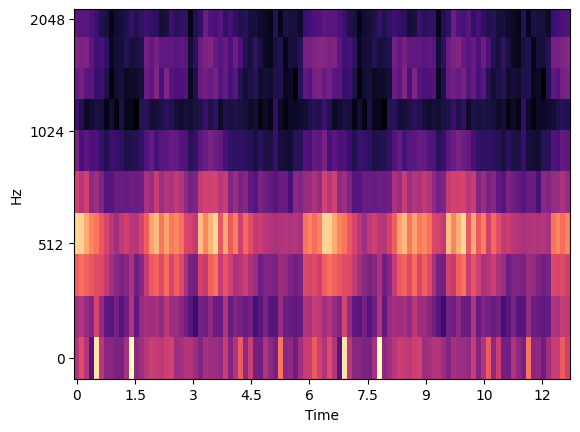

In [40]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(result.T, sr=4000, x_axis='time', y_axis='mel')

In [20]:
np.min(result)

-10.035218099210814

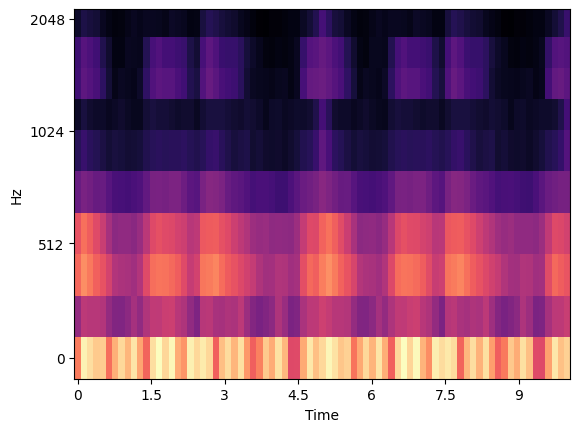

In [41]:
audio_data = np.array(test, dtype=np.float32)
mel = librosa.feature.melspectrogram(y=audio_data, sr=4000, n_mels=10)
mel = librosa.power_to_db(mel, ref=np.max)
librosa.display.specshow(mel, sr=4000, x_axis='time', y_axis='mel')

In [112]:
np.max(mel)

0.0